In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import ast
import seaborn as sns
import json, requests, time
import plotly.express as px
from numpy.linalg import inv
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sqlalchemy import create_engine

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, mean_squared_error

engine = create_engine('postgresql://postgres:argmax@pg:5432/postgres')

# Data
Every time a user opens a mobile app, an auction is going on behind the scenes. The highest bidder gets to advertise his ad to the user.
## Auctions Table

In [ ]:
sql_query = 'SELECT * FROM auctions;'
with engine.connect() as db_con:
    df = pd.read_sql(sql_query, con=db_con)

## App Vectors table
We've gathered the first few sentences from the app store description and embedded it with a [model](https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)

In [ ]:
sql_query = f'''
SELECT
    *
FROM app_vectors
'''
has_embedding = False
while not has_embedding:
    with engine.connect() as db_con:
        df = pd.read_sql(sql_query, con=db_con)
    has_embedding = (~df["embedding"].isna()).all()
    if not has_embedding:
        print("Waiting for embeddings...")
        
        time.sleep(15)


We can use the `<=>` operator to run vector search within the database

In [ ]:
vec = json.loads(df.embedding[1]) # get the first embedding
print ("Embedding size: {l}".format(l=len(vec)))

sql_query = f'''
SELECT
    "bundleId"
FROM app_vectors
ORDER BY embedding<=>'{json.dumps(vec)}'
'''
with engine.connect() as db_con:
    df__ = pd.read_sql(sql_query, con=db_con)

df__

# What you need to do
## The hypothesis
We assume that apps with similar desciptions, would have a similar asking price in the auctions (`sentPrice` column).

Use cosine similarity (`<=>`) on the embeddings to find similar apps, and any statistical tools you find suitable to prove or disprove this hypothesis.

## Is it consistent?
There are several other features in the auctions table (such as `CountryCode` and `OS`), 
Do your findings hold for those as well?

In [ ]:
%pip install seaborn
%pip install matplotlib
%pip install scikit-learn
%pip install plotly
!jupyter nbextension enable --py widgetsnbextension
%pip install ipywidgets

In [ ]:
# TODO: Please write your analysis here

In [2]:
## func section 
def get_auctions_data_from_sql(engine, sql_query = 'SELECT * FROM auctions;'):
    
    with engine.connect() as db_con:
        auction_df = pd.read_sql(sql_query, con=db_con)
        
    return auction_df

def get_app_vectors_data_from_sql(engine, sql_query = 'SELECT * FROM app_vectors;'):
    
    has_embedding = False
    while not has_embedding:
        with engine.connect() as db_con:
            app_vectors_df = pd.read_sql(sql_query, con=db_con)
        has_embedding = (~app_vectors_df["embedding"].isna()).all()
        
        if not has_embedding:
            print("Waiting for embeddings...")
            time.sleep(15)
            
    return app_vectors_df

def plot_sorted_by_price_distribution(auction_df, first_column, second_column, first_word = "iOS", second_word = "Android", ios_step=10, and_step=10):
    # Function to adjust ticks
    def adjust_ticks(labels, step):
        return [label for index, label in enumerate(labels) if index % step == 0], [index for index in range(len(labels)) if index % step == 0]

    # Calculate value counts and sort them for both OS versions
    ios_value_counts_sorted = auction_df[auction_df[first_column].str.contains(first_word, na=False)][second_column].value_counts().sort_index(ascending=True)
    and_value_counts_sorted = auction_df[auction_df[first_column].str.contains(second_word, na=False)][second_column].value_counts().sort_index(ascending=True)

    # Determine steps for tick intervals
    ios_step = max(1, len(ios_value_counts_sorted) // ios_step)
    and_step = max(1, len(and_value_counts_sorted) // and_step)

    # Recalculate tick positions and labels
    ios_thin_labels, ios_thin_ticks = adjust_ticks(ios_value_counts_sorted.index.tolist(), ios_step)
    and_thin_labels, and_thin_ticks = adjust_ticks(and_value_counts_sorted.index.tolist(), and_step)

    # Increase figure size for better clarity
    plt.figure(figsize=(10, 8))

    # iOS Plot adjustments
    plt.subplot(2, 1, 1)
    sns.barplot(x=ios_value_counts_sorted.index, y=ios_value_counts_sorted.values)
    plt.title(f'{first_word} {second_column} Distribution')
    plt.xlabel(second_column)
    plt.ylabel('Frequency')
    plt.xticks(ticks=ios_thin_ticks, labels=ios_thin_labels, rotation=45)

    # Android Plot adjustments
    plt.subplot(2, 1, 2)
    sns.barplot(x=and_value_counts_sorted.index, y=and_value_counts_sorted.values)
    plt.title(f'{second_word} {second_column} Distribution')
    plt.xlabel(second_column)
    plt.ylabel('Frequency')
    plt.xticks(ticks=and_thin_ticks, labels=and_thin_labels, rotation=45)

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

# Assuming we have some function to get vectors (embeddings) for bundle IDs
def get_embedding(bundle_id):
    return bundle_id_to_embedding.get(bundle_id, None)
    
# Function to get similar apps based on Mahalanobis distance
def find_similar_apps_mahalanobis(bundle_id, top_n=10):
    
    # Define Mahalanobis distance function
    def mahalanobis_distance(vec1, vec2, inv_cov_matrix):
        delta = vec1 - vec2
        m_distance = np.dot(np.dot(delta, inv_cov_matrix), delta)
        return np.sqrt(max(m_distance, 0))  # Prevent negative values under the square root

    target_vec = get_embedding(bundle_id)
    if target_vec is not None:
        distances = []
        for other_id, other_vec in bundle_id_to_embedding.items():
            if other_id != bundle_id:
                dist = mahalanobis_distance(np.array(target_vec), np.array(other_vec), inverse_covariance_matrix)
                distances.append((other_id, dist))
        # Sort by distance, return closest apps
        distances.sort(key=lambda x: x[1])
        return [bundle_id for bundle_id, dist in distances[:top_n]]
    else:
        return []

def find_similar_apps_cosine(bundle_id, top_n=10):
    # Check if the bundle_id is in the app_similarity dictionary
    if bundle_id in app_similarity and 'cosine' in app_similarity[bundle_id]:
        # Fetch the list of similar apps based on cosine similarity
        similar_apps = app_similarity[bundle_id]['cosine']
        # Return the top N similar apps, or all if there are fewer than N
        return similar_apps[:top_n]
    else:
        # Return an empty list if no similarities are found or the app isn't in the dictionary
        return []

# Function to calculate average price for a list of apps
def calculate_average_price(similar_apps, auction_data):
    
    prices = auction_data[auction_data['bundleId'].isin(similar_apps)]['sentPrice']
    return prices.mean() if not prices.empty else None
   
def get_fallback_prices(new_row, auction_df):
    fallbacks = [
        ('unitDisplayType', 'countryCode'),  # First level fallback
        ('brandName', 'countryCode'),       # Second level fallback
        ('bundleId', 'countryCode'),
        ('bundleId',), # Third level fallback
        ()                                  # Final fallback to overall average
    ]
    for attributes in fallbacks:
        if attributes:  # If there are attributes to consider
            avg_price = auction_df.groupby(list(attributes))['sentPrice'].mean().to_dict()
            key = tuple(new_row[attr] for attr in attributes if attr in new_row)
            if key in avg_price:
                return avg_price[key]
        else:  # No more attributes to consider, return overall average
            return auction_df['sentPrice'].mean()
    return None  # Should never reach here if overall average exists

# Naive approach for price prediction
def predict_price_naive(new_auction, auction):
    return avg_price_by_combination.get(
        (new_auction['unitDisplayType'], new_auction['brandName'], new_auction['bundleId'], 
         new_auction['countryCode'], new_auction['osAndVersion']),
        get_fallback_prices(new_auction, auction))

def apply_naive_prediction(row):
    """Apply naive price prediction based on a single auction row."""
    return predict_price_naive(row, auction_train)


def plot_pca(dataframe1, df2, n_components, category_column, file_name):
    """
    Plots a 2D or 3D PCA scatter plot based on the number of components.

    Parameters:
    - dataframe: DataFrame containing the features.
    - n_components: Number of PCA components (2 or 3).
    - category_column: Column name in the original dataframe to color the points by categories.

    Returns:
    - Plotly figure
    """
    # Check if n_components is either 2 or 3
    if n_components not in [2, 3]:
        raise ValueError("n_components must be 2 or 3.")
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(dataframe1)
    
    # Create a DataFrame for the PCA components
    pca_columns = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(data=components, columns=pca_columns)
    
    # Adding the category column for coloring
    pca_df[category_column] = df2[category_column].values
    
    # Plotting
    if n_components == 3:
        fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color=category_column,
                            title=f'{n_components}D PCA Visualization')
    else:
        fig = px.scatter(pca_df, x='PC1', y='PC2', color=category_column,
                         title=f'{n_components}D PCA Visualization')
    
    # fig.show()
    fig.write_html(f"{file_name}.html")


def plot_tsne(dataframe1, df2, n_components, category_column, file_name, perplexity=30):
    """
    Plots a 2D or 3D t-SNE scatter plot based on the number of components.

    Parameters:
    - dataframe1: DataFrame containing the features for t-SNE.
    - df2: DataFrame containing the categories for coloring the points.
    - n_components: Number of t-SNE components (2 or 3).
    - category_column: Column name in the original dataframe to color the points by categories.
    - file_name: The name of the file to save the HTML plot.
    - perplexity: The perplexity is a parameter for t-SNE, related to the number of nearest neighbors.
    
    Returns:
    - Plotly figure saved as an HTML file.
    """
    # Check if n_components is either 2 or 3
    if n_components not in [2, 3]:
        raise ValueError("n_components must be 2 or 3.")
    
    # Perform t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate='auto', init='random')
    components = tsne.fit_transform(dataframe1)
    
    # Create a DataFrame for the t-SNE components
    tsne_columns = [f'Component{i+1}' for i in range(n_components)]
    tsne_df = pd.DataFrame(data=components, columns=tsne_columns)
    
    # Adding the category column for coloring
    tsne_df[category_column] = df2[category_column].values
    
    # Plotting
    if n_components == 3:
        fig = px.scatter_3d(tsne_df, x='Component1', y='Component2', z='Component3', color=category_column,
                            title=f'{n_components}D t-SNE Visualization')
    else:  # 'otherwise' is corrected to 'else'
        fig = px.scatter(tsne_df, x='Component1', y='Component2', color=category_column,
                         title=f'{n_components}D t-SNE Visualization')
    
    # Saving the figure as HTML
    fig.write_html(f"{file_name}.html")


def print_mean_std(df):
    average_price = df['sentPrice'].mean()
    std_price = df['sentPrice'].std()
    print(f"Average sent price across all auctions: {average_price} +- {std_price}; max: {df['sentPrice'].max()}; min: {df['sentPrice'].min()}\n")
    
    average_price = df['bidFloorPrice'].mean()
    std_price = df['bidFloorPrice'].std()
    print(f"Average bid price across all auctions: {average_price} +- {std_price}; max: {df['bidFloorPrice'].max()}; min: {df['bidFloorPrice'].min()}")

def print_group_mean_std(df, by_col = []):

    filtered_avg_std_price_by_display = df.groupby('unitDisplayType')[['bidFloorPrice', 'sentPrice']].agg(['mean', 'std'])
    print(filtered_avg_std_price_by_display)

In [3]:
## Start preproccesing 
# Load the data from SQL
engine = create_engine('postgresql://postgres:argmax@pg:5432/postgres')

auction_df = get_auctions_data_from_sql(engine, sql_query = 'SELECT * FROM auctions;')
app_vectors_df = get_app_vectors_data_from_sql(engine, sql_query = 'SELECT * FROM app_vectors;')
app_vectors_df.drop_duplicates(subset=['bundleId', 'content', 'embedding'], keep='first', inplace=True)
app_vectors_df['embedding'] = app_vectors_df['embedding'].apply(ast.literal_eval)


encoded_auction_df = auction_df.copy()
encoded_auction_df = encoded_auction_df[['unitDisplayType', 'brandName', 'bundleId', 'countryCode', 'osAndVersion']]
encoded_auction_df = pd.get_dummies(encoded_auction_df, columns=['unitDisplayType', 'brandName', 'bundleId', 'countryCode', 'osAndVersion'])
encoded_auction_df = encoded_auction_df.astype(int)
encoded_auction_df['sentPrice'] = auction_df['sentPrice']
encoded_auction_df['bidFloorPrice'] = auction_df['bidFloorPrice']

sequence_lookup = app_vectors_df.set_index('bundleId')['embedding'].to_dict()
auction_df['embedding'] = auction_df['bundleId'].map(sequence_lookup)
# encoded_auction_df['embedding'] = auction_df['embedding'].copy()

# Filter the whoal dataframe by sentPrice frequences; ent_price_counts > 5
sent_price_counts = auction_df['sentPrice'].value_counts()
mask = auction_df['sentPrice'].isin(sent_price_counts[sent_price_counts > 5].index)
filtered_auction_df = auction_df[mask]

print(auction_df.shape)
print(encoded_auction_df.shape)
print(filtered_auction_df.shape)

(207920, 11)
(207920, 440)
(203990, 11)


In [4]:
auction_df.head(3) 

,id,eventTimestamp,unitDisplayType,brandName,bundleId,countryCode,deviceId,osAndVersion,bidFloorPrice,sentPrice,embedding
0,1,1657758857892,rewarded,Generic,com.loop.match3d,US,6a0a94554cf,Android-4.0,0.05,0.06,"[0.31683534, 0.625009, -0.120355725, 0.2174228..."
1,2,1657210707978,interstitial,Generic,com.loop.match3d,ZA,6a0b0e59f45,Android-4.0,0.01,0.16,"[0.31683534, 0.625009, -0.120355725, 0.2174228..."
2,3,1657392939412,interstitial,Motorola,com.YayySAL.DodgeAgent,BR,6a0fa820c46,Android-10.0,0.05,0.06,"[0.54112804, 0.74467534, -0.5817448, 0.9596779..."


In [5]:
encoded_auction_df.head(3)

,unitDisplayType_banner,unitDisplayType_interstitial,unitDisplayType_rewarded,brandName_A1,brandName_AT&T,brandName_Acer,brandName_Advan,brandName_Aidata,brandName_Alba,brandName_Alcatel,...,osAndVersion_iOS-15.2.1,osAndVersion_iOS-15.3,osAndVersion_iOS-15.3.1,osAndVersion_iOS-15.4,osAndVersion_iOS-15.4.1,osAndVersion_iOS-15.5,osAndVersion_iOS-15.6,osAndVersion_iOS-16.0,sentPrice,bidFloorPrice
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.06,0.05
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.16,0.01
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.06,0.05


In [81]:
# Check for missing values and data types
print(auction_df.info())
print(app_vectors_df.info())
print(filtered_auction_df['bundleId'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166336 entries, 0 to 166335
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               166336 non-null  int64  
 1   eventTimestamp   166336 non-null  object 
 2   unitDisplayType  166336 non-null  object 
 3   brandName        166336 non-null  object 
 4   bundleId         166336 non-null  object 
 5   countryCode      166336 non-null  object 
 6   deviceId         166336 non-null  object 
 7   osAndVersion     166336 non-null  object 
 8   bidFloorPrice    166336 non-null  float64
 9   sentPrice        166336 non-null  float64
 10  embedding        166336 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 14.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         18 non-null     int

In [83]:
# Descriptive Statistics
print(auction_df[['bidFloorPrice', 'sentPrice']].describe())

       bidFloorPrice      sentPrice
count  166336.000000  166336.000000
mean        0.059684       1.329646
std         0.411748       7.118753
min         0.010000       0.010000
25%         0.010000       0.030000
50%         0.010000       0.070000
75%         0.050000       0.440000
max         5.000000     441.020000


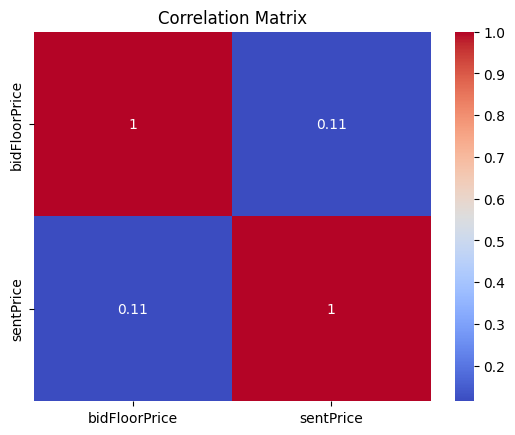

In [86]:
# Visualization: Correlation Matrix
corr_matrix = auction_df[['bidFloorPrice', 'sentPrice']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [91]:
print_mean_std(auction_df)

Average sent price across all auctions: 1.3296457772220083 +- 7.118752937017689; max: 441.02; min: 0.01

Average bid price across all auctions: 0.059684013081954576 +- 0.411748272447735; max: 5.0; min: 0.01


In [12]:
print_mean_std(filtered_auction_df)

Average sent price across all auctions: 0.8147330751507428 +- 3.701460032076104; max: 255.0; min: 0.01

Average bid price across all auctions: 0.05453134957595961 +- 0.37871501960391285; max: 5.0; min: 0.01


In [24]:
print_group_mean_std(auction_df, ['unitDisplayType'])
print_group_mean_std(auction_df, ['countryCode'])
print_group_mean_std(auction_df, ['osAndVersion'])
print_group_mean_std(auction_df, ['unitDisplayType', 'countryCode'])

                bidFloorPrice           sentPrice           
                         mean       std      mean        std
unitDisplayType                                             
banner               0.028404  0.025642  0.145853   0.364556
interstitial         0.157167  0.809869  1.897213   7.507471
rewarded             0.022703  0.018622  3.423439  12.363627
            bidFloorPrice           sentPrice          
                     mean       std      mean       std
countryCode                                            
AD               0.010000  0.000000  0.110000  0.000000
AE               0.023835  0.019044  1.094737  3.639097
AF               0.025000  0.019675  0.246250  0.472193
AL               0.020526  0.017672  0.177632  0.233311
AM               0.020909  0.017917  0.235909  0.360761
...                   ...       ...       ...       ...
VN               0.022581  0.019143  0.501848  0.913856
XK               0.010000  0.000000  0.200000  0.000000
ZA               0

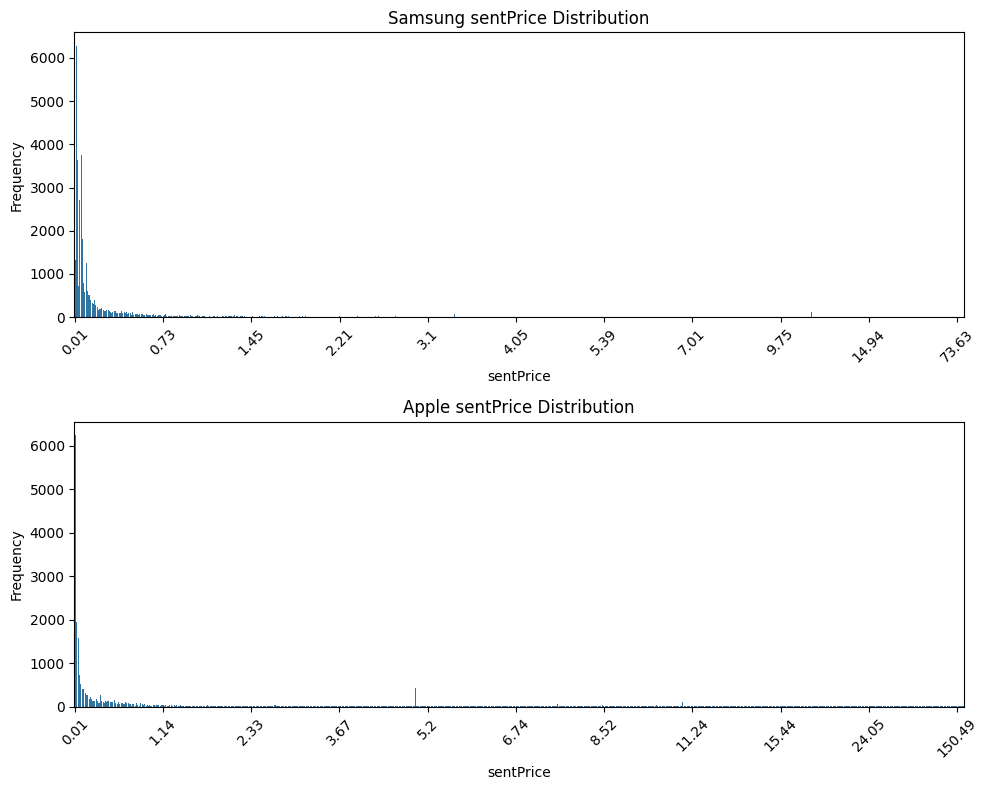

In [63]:
plot_sorted_by_price_distribution(auction_df, 'brandName', 'sentPrice', "Samsung", "Apple")
# plot_sorted_by_price_distribution(auction_df, 'bundleId', 'sentPrice', "iOS", "Android", ios_step=10, and_step=10)


In [ ]:
# print(filtered_auction_df['bundleId'].value_counts())
# print()
# print(filtered_auction_df['brandName'].value_counts())
# print()
# print(filtered_auction_df['unitDisplayType'].value_counts())
# print()
# print(filtered_auction_df['countryCode'].value_counts())
# print()
# print(filtered_auction_df['osAndVersion'].value_counts())

In [49]:
plot_pca(encoded_auction_df, auction_df, 2, 'bundleId', '2pc_pca')

In [84]:
plot_pca(encoded_auction_df, auction_df, 3, 'bundleId', '3pc_pca')

In [88]:
plot_tsne(encoded_auction_df, auction_df, 2, 'bundleId', '2pc_tsne', perplexity=30)

In [91]:
plot_tsne(encoded_auction_df, auction_df, 3, 'bundleId', '3pc_tsne', perplexity=30)

In [28]:
auction_df_ = auction_df[:90000]# .sample(frac=0.2)

In [29]:
# Split the auction data into training and testing sets (more for control and evaluation)
auction_train, auction_test = train_test_split(auction_df_, test_size=0.2, random_state=42, shuffle=True, 
                                               stratify=auction_df_['sentPrice'])  # 20% of data for testing

In [30]:
# Calculate the overall average sentPrice
overall_avg_sent_price = auction_train['sentPrice'].mean()
overall_mesian_sent_price = auction_train['sentPrice'].median()
print(f"Overall mean sent price: {overall_avg_sent_price}")
print(f"Overall median sent price: {overall_mesian_sent_price}")
# Calculate average sentPrice for each combination of attributes
avg_price_by_combination = auction_train.groupby(['unitDisplayType', 'brandName', 'bundleId', 'countryCode', 'osAndVersion'])['sentPrice'].mean()
print(auction_train.groupby(['bundleId'])['sentPrice'].mean().sort_values(ascending=False))

Overall mean sent price: 1.3575175
Overall median sent price: 0.07
bundleId
1569586264                     18.519307
1436213906                      4.774502
1529614832                      3.405794
com.tilegarden.match3           2.339068
1502447854                      2.293563
1582745578                      2.258511
1542256628                      2.021179
se.ace.fishinc                  1.859117
1586795332                      1.668299
com.loop.match3d                1.456066
1523081624                      1.122717
1579489488                      1.088222
dovi.coalmining.inc             0.624380
com.kamilbilge.ropesavior3d     0.469049
com.volt.dresstoimpress         0.432701
com.YayySAL.DodgeAgent          0.419510
com.tintash.nailsalon           0.305604
com.AppIdeas.LevelUpRunner      0.131861
Name: sentPrice, dtype: float64


In [31]:
# Create a mapping from bundleId to embedding for faster lookup
# bundle_id_to_embedding = {row['bundleId']: json.loads(row['embedding']) for index, row in app_vectors_df.iterrows()}
bundle_id_to_embedding = sequence_lookup
# Dictionary to hold the similarity results for each app
app_similarity = {}

# Iterate through each unique app in the auction data
for bundle_id in auction_df['bundleId'].unique():
    # Find the embedding for the current app
    if bundle_id in bundle_id_to_embedding:
        vec = bundle_id_to_embedding[bundle_id]

        # Prepare and execute the SQL query to find similar apps based on cosine similarity
        sql_query = f'''
        SELECT
            "bundleId"
        FROM app_vectors
        ORDER BY embedding<=>'{json.dumps(vec)}'
        '''
        with engine.connect() as db_con:
            similar_apps_df = pd.read_sql(sql_query, con=db_con)

        similar_apps_df.drop_duplicates(keep='first', inplace=True)
        # Exclude the current app from its list of similar apps
        similar_apps_list = similar_apps_df['bundleId'].tolist()
        if bundle_id in similar_apps_list:
            similar_apps_list.remove(bundle_id)
        
        # app_similarity[bundle_id] = similar_apps_list
        app_similarity[bundle_id] = {'cosine': similar_apps_list}
    else:
        app_similarity[bundle_id] = []

In [32]:
# Calculate the inverse covariance matrix from all vectors
all_vectors = np.array(list(bundle_id_to_embedding.values()))
covariance_matrix = np.cov(all_vectors, rowvar=False)
inverse_covariance_matrix = inv(covariance_matrix)

# Adding Mahalanobis similar apps to the dictionary
for bundle_id in filtered_auction_df['bundleId'].unique():
    if bundle_id in bundle_id_to_embedding:
        similar_apps_mahalanobis = find_similar_apps_mahalanobis(bundle_id)
        app_similarity[bundle_id]['mahalanobis'] = similar_apps_mahalanobis

In [ ]:
# Apply predictions across the test set
auction_test['predicted_price_naive'] = auction_test.apply(apply_naive_prediction, axis=1)

In [33]:
predicted_prices_cosine = []
predicted_prices_mahalanobis = [] 

for index, row in auction_test.iterrows():
    
    similar_apps_cosine = find_similar_apps_cosine(row['bundleId'], top_n=3)
    predicted_prices_cosine.append(calculate_average_price(similar_apps_cosine, auction_train))
    
    similar_apps_mahalanobis = find_similar_apps_mahalanobis(row['bundleId'], top_n=5)
    predicted_prices_mahalanobis.append(calculate_average_price(similar_apps_mahalanobis, auction_train))

auction_test['predicted_price_cosine'] = predicted_prices_cosine
auction_test['predicted_price_mahalanobis'] = predicted_prices_mahalanobis 

In [35]:
# Calculate errors across all test predictions
# mse_naive = mean_squared_error(auction_test['sentPrice'], auction_test['predicted_price_naive'])
mse_cosine = mean_squared_error(auction_test['sentPrice'], auction_test['predicted_price_cosine'].fillna(0))  # Fill NA if there's no prediction
mse_mahalanobis = mean_squared_error(auction_test['sentPrice'], auction_test['predicted_price_mahalanobis'].fillna(0))  # Fill NA if there's no prediction

# Print out overall MSE results for comparison
# print(f"Overall MSE (Naive): {mse_naive}")
print(f"Overall MSE (Cosine): {mse_cosine}")
print(f"Overall MSE (mahalanobis): {mse_mahalanobis}")

Overall MSE (Cosine): 43.6361296845115
Overall MSE (mahalanobis): 43.4743988503067


In [36]:
# Generate a new auction row with random values from each column
new_auction = {
    'sentPrice': float(),  # Placeholder for the predicted price
    'unitDisplayType': np.random.choice(auction_test['unitDisplayType']),
    'brandName': np.random.choice(auction_test['brandName']),
    'bundleId': np.random.choice(auction_test['bundleId']),
    'countryCode': np.random.choice(auction_test['countryCode']),
    'deviceId': np.random.choice(auction_test['deviceId']),
    'osAndVersion': np.random.choice(auction_test['osAndVersion'])
}
new_auction['sentPrice'] = float(auction_test[auction_test['deviceId'] == new_auction['deviceId']]['sentPrice'])
new_auction

{'sentPrice': 0.06,
 'unitDisplayType': 'banner',
 'brandName': 'Apple',
 'bundleId': '1502447854',
 'countryCode': 'CA',
 'deviceId': '6a33cdf996c',
 'osAndVersion': 'Android-11.0'}

In [37]:
predicted_prices_cosine = []
predicted_prices_mahalanobis = [] 
for index, row in auction_test.iterrows():
    similar_apps_cosine = find_similar_apps_cosine(row['bundleId'], top_n=3)
    predicted_prices_cosine.append(calculate_average_price(similar_apps_cosine, auction_train))
    
    similar_apps_mahalanobis = find_similar_apps_mahalanobis(row['bundleId'], top_n=3)
    predicted_prices_mahalanobis.append(calculate_average_price(similar_apps_mahalanobis, auction_train))

auction_test['predicted_price_cosine'] = predicted_prices_cosine
auction_test['predicted_price_mahalanobis'] = predicted_prices_mahalanobis 
auction_test['predicted_price_naive'] = auction_test.apply(apply_naive_prediction, axis=1)

# Calculate errors across all test predictions
mse_naive = mean_squared_error(auction_test['sentPrice'], auction_test['predicted_price_naive'])
mse_cosine = mean_squared_error(auction_test['sentPrice'], auction_test['predicted_price_cosine'].fillna(0))  # Fill NA if there's no prediction
mse_mahalanobis = mean_squared_error(auction_test['sentPrice'], auction_test['predicted_price_mahalanobis'].fillna(0))  # Fill NA if there's no prediction

# Print out overall MSE results for comparison
print(f"Overall MSE (Naive): {mse_naive}")
print(f"Overall MSE (Cosine): {mse_cosine}")
print(f"Overall MSE (mahalanobis): {mse_mahalanobis}")

Overall MSE (Naive): 33.264980539752955
Overall MSE (Cosine): 43.6361296845115
Overall MSE (mahalanobis): 43.79346020165977


In [ ]:
plt.figure(figsize=(21, 7))  # Extend figure size to accommodate three subplots

# Plot for Naive Predictions
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
sns.scatterplot(x=auction_test['sentPrice'], y=auction_test['predicted_price_naive'])
plt.title('Actual vs. Naive Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Naive Predicted Prices')

# Plot for Cosine Similarity Predictions
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
sns.scatterplot(x=auction_test['sentPrice'], y=auction_test['predicted_price_cosine'])
plt.title('Actual vs. Cosine Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Cosine Predicted Prices')

# Plot for Mahalanobis Distance Predictions
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
sns.scatterplot(x=auction_test['sentPrice'], y=auction_test['predicted_price_mahalanobis'].fillna(0))  # Filling NA if there's no prediction
plt.title('Actual vs. Mahalanobis Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Mahalanobis Predicted Prices')

plt.tight_layout()
plt.show()

In [ ]:
## func section 
def add_embeddings(df, embedding_dict):
    
    default_embedding = [0] * len(next(iter(embedding_dict.values())))
    df['embedding'] = df['bundleId'].apply(lambda x: embedding_dict.get(x, default_embedding))
    
    embeddings = df['embedding'].tolist()
    
    new_columns = [f'emb_{i}' for i in range(len(default_embedding))]
    df[new_columns] = pd.DataFrame(embeddings, index=df.index)
    
    return df, new_columns
    
def train_linear_regression(X_train, y_train, X_test, y_test):
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    
    predictions = lin_reg.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"MSE for Linear Regression: {mse}")
    
    return lin_reg

def apply_clustering(X_train_scaled, X_test_scaled, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters_train = kmeans.fit_predict(X_train_scaled)
    clusters_test = kmeans.predict(X_test_scaled)
    return clusters_train, clusters_test
    
def determine_optimal_clusters(X_scaled, max_clusters=10):

    silhouette_scores = []
    range_n_clusters = range(2, max_clusters + 1)  # At least 2 clusters are needed to define silhouette score

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    # Find the number of clusters that gives the maximum silhouette score
    optimal_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]

    # Plotting to find the "elbow"
    plt.figure()
    plt.plot(range_n_clusters, silhouette_scores, 'bo-')
    plt.title('Finding the Optimal Number of Clusters')
    plt.xlabel('Clusters')
    plt.ylabel('Inertia')
    plt.show()
    
    return optimal_clusters

def train_logistic_regression(X_train, y_train, X_test, y_test):
    parameters = {'C': [0.01, 0.05, 0.1, 0.5], 'max_iter': [100]}
    log_reg = LogisticRegression()
    clf = GridSearchCV(log_reg, parameters, cv=5)
    clf.fit(X_train, y_train)
    
    best_model = clf.best_estimator_
    predictions = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    print(f"Best parameters: {clf.best_params_}\n")
    print(f"Accuracy for Logistic Regression: {accuracy}\n")
    print(classification_report(y_test, predictions))
    
    return best_model

In [ ]:
# Apply this function to both datasets and capture the new column names for embeddings
auction_train, embedding_features = add_embeddings(auction_train.copy(), bundle_id_to_embedding)
auction_test, _ = add_embeddings(auction_test.copy(), bundle_id_to_embedding)

# Apply Machine Learning Models
X_train_emb = auction_train[embedding_features]
y_train = auction_train['sentPrice']
X_test_emb = auction_test[embedding_features]
y_test = auction_test['sentPrice']

# Scaling - important for regression and clustering with embedding features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_emb)
X_test_scaled = scaler.transform(X_test_emb)

In [ ]:
# Linear Regression with Embeddings
lin_reg_emb = train_linear_regression(X_train_scaled, y_train, X_test_scaled, y_test)
X_train_all = pd.get_dummies(auction_train[embedding_features], drop_first=True)

# Print the importance of features from the all-features model
print("Top 3 most important characteristics for predicting the price:")
importance = pd.Series(lin_reg_emb.coef_, index=X_train_emb.columns).sort_values(key=abs, ascending=False)
print(importance.head(12))

In [ ]:
# Apply Machine Learning Models
n = 10
X_train_emb_agn = auction_train[importance.index[:n].tolist()]
y_train = auction_train['sentPrice']
X_test_emb_agn = auction_test[importance.index[:n].tolist()]
y_test = auction_test['sentPrice']

# Scaling - important for regression and clustering with embedding features
scaler_agn = StandardScaler()
X_train_scaled_agn = scaler_agn.fit_transform(X_train_emb_agn)
X_test_scaled_agn = scaler_agn.transform(X_test_emb_agn)

# Linear Regression with Embeddings
lin_reg_emb_agn = train_linear_regression(X_train_scaled_agn, y_train, X_test_scaled_agn, y_test)

In [ ]:
all_features = ['unitDisplayType', 'brandName', 'countryCode', 'osAndVersion', 'bundleId']

# Regression with All Features
X_train_all = pd.get_dummies(auction_train[all_features], drop_first=True)
X_test_all = pd.get_dummies(auction_test[all_features], drop_first=True)
X_test_all = X_test_all.reindex(columns = X_train_all.columns, fill_value=0)  # Align columns

lin_reg_all = train_linear_regression(X_train_all, y_train, X_test_all, y_test)

# Print the importance of features from the all-features model
print("Top 3 most important characteristics for predicting the price:")
importance = pd.Series(lin_reg_all.coef_, index=X_train_all.columns).sort_values(key=abs, ascending=False)
print(importance.head(10))

In [ ]:
# Apply Machine Learning Models
n = 12
X_train_emb_agn = X_train_all[importance.index[:n].tolist()]
y_train = auction_train['sentPrice']
X_test_emb_agn = X_test_all[importance.index[:n].tolist()]
y_test = auction_test['sentPrice']

# Scaling - important for regression and clustering with embedding features
scaler_agn = StandardScaler()
X_train_scaled_agn = scaler_agn.fit_transform(X_train_emb_agn)
X_test_scaled_agn = scaler_agn.transform(X_test_emb_agn)

# Linear Regression with Embeddings
lin_reg_emb_agn = train_linear_regression(X_train_scaled_agn, y_train, X_test_scaled_agn, y_test)

In [ ]:
optimal_clusters = determine_optimal_clusters(X_train_scaled, max_clusters=10)
auction_train['cluster'], auction_test['cluster'] = apply_clustering(X_train_scaled, X_test_scaled, optimal_clusters)

In [ ]:
auction_train.groupby('cluster')['sentPrice'].median().sort_values(ascending=False)
auction_train.groupby('cluster')['sentPrice'].mean().sort_values(ascending=False)

In [ ]:
for cluster_index in auction_train['cluster'].unique():
    print(auction_train[auction_train['cluster'] == i].groupby('bundleId')['sentPrice'].mean().sort_values(ascending=False))

In [ ]:
auction_train['price_category'] = pd.qcut(auction_train['sentPrice'], 5, labels=['low', 'medium-', 'medium', 'medium+','high'])
auction_test['price_category'] = pd.qcut(auction_test['sentPrice'], 5, labels=['low', 'medium-', 'medium', 'medium+', 'high'])

# Prepare data for logistic regression
X_train_cat = auction_train[embedding_features]  # Assuming embeddings are numerical and correctly scaled
y_train_cat = auction_train['price_category']
X_test_cat = auction_test[embedding_features]
y_test_cat = auction_test['price_category']

# Make sure the embeddings are scaled
scaler_cat = StandardScaler()
X_train_cat_scaled = scaler_cat.fit_transform(X_train_cat)
X_test_cat_scaled = scaler_cat.transform(X_test_cat)

# Logistic Regression with Embeddings
log_reg_model_emb = train_logistic_regression(X_train_scaled, y_train_cat, X_test_scaled, y_test_cat)

In [ ]:
# Train Logistic Regression
log_reg_model_cat = train_logistic_regression(X_train_cat_scaled, y_train_cat, X_test_cat_scaled, y_test_cat)

In [ ]:
# Logistic Regression with Embeddings
log_reg_model_emb = train_logistic_regression(X_train_scaled, y_train_cat, X_test_scaled, y_test_cat)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare the dataset for regression analysis
X_train = auction_train[['unitDisplayType', 'brandName', 'countryCode']]  # Add more features as necessary
X_train = pd.get_dummies(X_train, drop_first=True)  # One-hot encode categorical features
y_train = auction_train['sentPrice']

# Similarly, prepare the test set
X_test = auction_test[['unitDisplayType', 'brandName', 'countryCode']]  # Ensure this matches the training set features
X_test = pd.get_dummies(X_test, drop_first=True)
y_test = auction_test['sentPrice']

# Handle any mismatch in columns after one-hot encoding between train and test sets
X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

# Perform Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions_lin = lin_reg.predict(X_test)

# Measure and print out the performance
mse_lin = mean_squared_error(y_test, predictions_lin)
print(f"MSE for Linear Regression: {mse_lin}")

# Importance of features
feature_importance = pd.Series(lin_reg.coef_, index=X_train.columns).sort_values(key=abs, ascending=False)
print("Top 3 most important features for predicting the price:")
feature_importance.head(3)